In [23]:
from keras.models import Sequential, load_model
from keras.layers import *
from keras import optimizers
from keras import utils
from keras.callbacks import TensorBoard, ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf

# Importing matplotlib to plot images.
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Importing SK-learn to calculate precision and recall
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneGroupOut
from sklearn.utils import shuffle 

# Used for graph export
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras import backend as K

import pickle as pkl
import h5py

from pathlib import Path
import os.path
import sys
import datetime
import time

In [24]:
class LoggingTensorBoard(TensorBoard):    

    def __init__(self, log_dir, settings_str_to_log, **kwargs):
        super(LoggingTensorBoard, self).__init__(log_dir, **kwargs)

        self.settings_str = settings_str_to_log

    def on_train_begin(self, logs=None):
        TensorBoard.on_train_begin(self, logs=logs)

        tensor =  tf.convert_to_tensor(self.settings_str)
        summary = tf.summary.text ("Run_Settings", tensor)

        with  tf.Session() as sess:
            s = sess.run(summary)
            self.writer.add_summary(s)

In [25]:
# the data, split between train and test sets
dfAll = pd.read_pickle("PklData/df_gestures.pkl")
df_train = dfAll[(dfAll.userID != 1) | (dfAll.userID != 2)]
df_test = dfAll[(dfAll.userID == 1) | (dfAll.userID == 2)]

df_test = df_test.reset_index()
df_train = df_train.reset_index()

df_train2 = df_train[['Gesture', 'TaskID']].copy()
df_test2 = df_test[['Gesture', 'TaskID']].copy()

In [26]:
less_errors = 0
more_errors = 0
for UserId in dfAll.userID.unique():
    for TaskId in dfAll[dfAll.userID == UserId].TaskID.unique():
        for VersionId in dfAll[(dfAll.userID == UserId) & (dfAll.TaskID == TaskId)].VersionID.unique():
            temp_len = len(dfAll[(dfAll.userID == UserId) & (dfAll.TaskID == TaskId) & (dfAll.VersionID == VersionId)].RepetitionID.unique())
            if temp_len < 1:
                less_errors += 1
            elif temp_len > 1:
                more_errors += 1
print("less: %s" % less_errors)
print("more: %s" % more_errors)

less: 0
more: 0


In [27]:
x_train = np.vstack(df_train2.Gesture)
x_test = np.vstack(df_test2.Gesture)
y_train = df_train2.TaskID.values
y_test = df_test2.TaskID.values

x_train = x_train.reshape(-1, 27, 15, 1)
x_test = x_test.reshape(-1, 27, 15, 1)

In [28]:
# convert class vectors to binary class matrices (one-hot notation)
num_classes = 34
y_train_one_hot = utils.to_categorical(df_train2.TaskID, num_classes)
y_test_one_hot = utils.to_categorical(df_test2.TaskID, num_classes)

# Plotting

In [29]:
dfAll.head()

,userID,TaskID,VersionID,RepetitionID,Gesture
0,4,19,2,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,4,19,3,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,4,19,4,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,4,19,5,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,4,19,6,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 16.0, 0.0..."


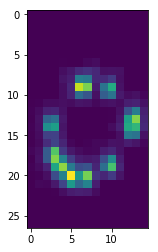

In [30]:
UserId = 6
TaskId = 8

data_point = dfAll[(dfAll.userID == UserId) & (dfAll.TaskID == TaskId)].iloc[0]

plt.imshow(data_point.Gesture)
plt.show()

Text(0.5, 1.0, 'Label for image 350 is: 1')

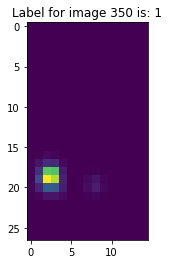

In [31]:
i = 350
plt.imshow(x_train[i].reshape(27, 15)) #np.sqrt(784) = 28
plt.title("Label for image %i is: %s" % (i, y_train[i]))

In [32]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
# config = tf.ConfigProto(device_count = {"GPU": 0})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'

# Limit the maximum memory used
#config.gpu_options.per_process_gpu_memory_fraction = 0.1

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [47]:
tf.get_default_graph()
########## HYPER PARAMETERS
batch_size = 50
epochs = 100
optimizer = optimizers.Adam()
#optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.1)
#init=tf.global_variables_initializer()

########## HYPER PARAMETERS
########## MODEL ARCHITECTURE
model = Sequential()


model.add(Conv2D(84, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(27,15,1)))
model.add(Conv2D(84, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format='channels_last'))
model.add(Dropout(0.15))
model.add(Conv2D(42, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(42, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', data_format='channels_last'))
model.add(Dropout(0.15))
model.add(Flatten())
model.add(Dense(400, activation=('relu'), use_bias=True))
model.add(Dense(100, activation=('relu'), use_bias=True))
model.add(Dense(num_classes, activation='softmax'))
########## MODEL ARCHITECTURE
####TENSORBOARD
config = ""
for layer in model.layers:
    config += str(layer.output).split('\"')[1].split("/")[0] + str(layer.output_shape) + "\n\n"
#### END TENSORBOARD


# Print summary
model.summary()
readable_timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')
tensorflowfolder = "/home/robin/Documents/TensorLogs/KnuckleFingerGestures_" + readable_timestamp

logger = LoggingTensorBoard(settings_str_to_log = config, log_dir=tensorflowfolder, histogram_freq=0, write_graph=True, write_images=True, update_freq = 'epoch')
storer = ModelCheckpoint("./ModelSnapshots/KnuckleFingerGestures_" + readable_timestamp + ".h5", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# compile model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(x_train, y_train_one_hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test_one_hot),
                    callbacks=[logger, storer])
                    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 27, 15, 84)        840       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 27, 15, 84)        63588     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 13, 7, 84)         0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 13, 7, 84)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 13, 7, 42)         31794     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 13, 7, 42)         15918     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 3, 42)          0         
__________

In [48]:
# use model for inference to get test accuracy
y_test_pred = model.predict(x_test)
y_test_pred = np.argmax(y_test_pred, axis=1)

#print ('\n Summary of the precision, recall, F1 score for each class:')
#print (sklearn.metrics.classification_report(y_test, y_test_pred))

print ('\n Confusion matrix: ')
np.set_printoptions(threshold=np.nan, linewidth=160)
print (sklearn.metrics.confusion_matrix(y_test, y_test_pred))


 Confusion matrix: 
[[32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 33  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 31  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 35  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 31  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 31  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 37  0

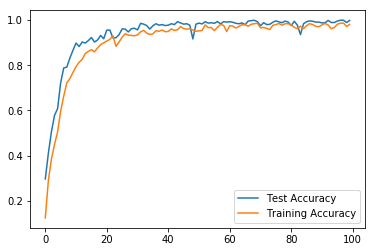

In [49]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_acc'], label="Test Accuracy")
plt.plot(history.history['acc'], label="Training Accuracy")
plt.legend()

In [50]:
# save model
model.save("Gestures.h5")